# Deep Learning Term Project for ECG (DIL700)

# Iteration 3

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
# # Original data

# train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
# test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# # Put together the training and testing
# full_df=pd.concat([train_df,test_df],ignore_index=True)

# Synthetic data

train_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_train.csv')
train_df = train_df.iloc[:, :-1]
train_df.rename(columns={'class': 187}, inplace=True)
test_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_test.csv')
test_df = test_df.iloc[:, :-1]
test_df.rename(columns={'class': 187}, inplace=True)

# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
# train_df = train_df[train_df[187] != 3]
# test_df = test_df[test_df[187] != 3]
# full_df = full_df[full_df[187] != 3]

# train_df = train_df[train_df[187] != '3.0']
# test_df = test_df[test_df[187] != '3.0']
# full_df = full_df[full_df[187] != '3.0']

train_df = train_df[train_df[187] != 'class']
test_df = test_df[test_df[187] != 'class']
full_df = full_df[full_df[187] != 'class']

# train_df.loc[train_df[187] == 4, 187] = 3.0
# test_df.loc[test_df[187] == 4, 187] = 3.0
# full_df.loc[full_df[187] == 4, 187] = 3.0

# train_df.loc[train_df[187] == '4.0', 187] = 3.0
# test_df.loc[test_df[187] == '4.0', 187] = 3.0
# full_df.loc[full_df[187] == '4.0', 187] = 3.0

train_df.loc[train_df[187] == '0.0', 187] = 0.0
train_df.loc[train_df[187] == '1.0', 187] = 1.0
train_df.loc[train_df[187] == '2.0', 187] = 2.0
train_df.loc[train_df[187] == '3.0', 187] = 3.0
train_df.loc[train_df[187] == '4.0', 187] = 4.0

In [4]:
print(train_df[187].unique())

[0. 1. 2. 4. 3.]


In [7]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Fusion', 'Paced']
labels_short =  ["N","S","V",'F',"Q"]

In [8]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))
print(labels[4],':', len(train_df[train_df[187]==4]))

Number of samples in data:
Normal : 77000
Artial Premature : 4402
Premature ventricular contraction : 6151
Fusion : 1988
Paced : 6833


In [9]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))
print(labels[4],':', len(test_df[test_df[187]==4]))

Number of samples in data:
Normal : 13589
Artial Premature : 777
Premature ventricular contraction : 1085
Fusion : 351
Paced : 1206


## Preparation

In [10]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"})

In [11]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
21600,0.990421,0.992337,0.442529,0.076628,0.021073,0.003831,0.000000,0.015326,0.070881,0.210728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69705,1.000000,0.734940,0.521084,0.262048,0.198795,0.063253,0.018072,0.006024,0.000000,0.021084,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16500,1.000000,0.812950,0.384892,0.241007,0.226619,0.197842,0.194245,0.179856,0.183453,0.165468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43226,1.000000,0.882759,0.468966,0.000000,0.043678,0.342529,0.432184,0.413793,0.416092,0.434483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33811,1.000000,0.927790,0.660832,0.404814,0.177243,0.142232,0.094092,0.091904,0.065646,0.076586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38510,1.000000,0.892031,0.694087,0.388175,0.298201,0.272494,0.249357,0.233933,0.159383,0.172237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19805,1.000000,0.874419,0.106977,0.000000,0.120930,0.125581,0.125581,0.118605,0.111628,0.102326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41091,1.000000,0.763780,0.125984,0.015748,0.086614,0.066929,0.043307,0.051181,0.035433,0.019685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4546,1.000000,0.969058,0.781997,0.604782,0.554149,0.524613,0.478200,0.476793,0.483826,0.479606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
y_train

21600    0.0
69705    0.0
16500    0.0
43226    0.0
33811    0.0
        ... 
38510    0.0
19805    0.0
41091    0.0
4546     0.0
77955    0.0
Name: 187, Length: 77099, dtype: float64

In [13]:
y_train_nn

,N,S,V,F,Q
21600,1,0,0,0,0
69705,1,0,0,0,0
16500,1,0,0,0,0
43226,1,0,0,0,0
33811,1,0,0,0,0
...,...,...,...,...,...
38510,1,0,0,0,0
19805,1,0,0,0,0
41091,1,0,0,0,0
4546,1,0,0,0,0


In [14]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
87325,0.994978,0.779717,0.200245,0.032748,0.110080,0.117585,0.097925,0.104381,0.166311,0.153726,...,-0.001074,-0.014685,0.006437,-0.010166,-0.000661,-0.002251,0.00237,0.004682,0.017074,0.000424
54345,1.000000,0.894521,0.638356,0.347945,0.164384,0.168493,0.160274,0.131507,0.120548,0.108219,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
94652,0.941748,0.841424,0.220065,0.004854,0.244337,0.268608,0.262136,0.268608,0.270227,0.263754,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
52052,0.968227,0.764214,0.122074,0.000000,0.237458,0.280936,0.244147,0.240803,0.247492,0.245819,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
51634,0.936620,0.852113,0.492958,0.126761,0.021127,0.190141,0.299296,0.267606,0.320423,0.299296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90139,1.000000,0.939281,0.744734,0.418835,0.142503,0.130112,0.142503,0.117720,0.092937,0.079306,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
70729,0.894602,0.704370,0.046272,0.000000,0.156812,0.215938,0.239075,0.262211,0.277635,0.282776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
37316,1.000000,0.601399,0.000000,0.066434,0.080420,0.108392,0.150350,0.146853,0.155594,0.152098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
80011,0.978632,0.820513,0.478632,0.059829,0.000000,0.145299,0.136752,0.170940,0.217949,0.243590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


## Dataset Distribution

### Training set

In [15]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    77000
1     4402
2     6151
4     6833
3     1988
Name: 187, dtype: int64


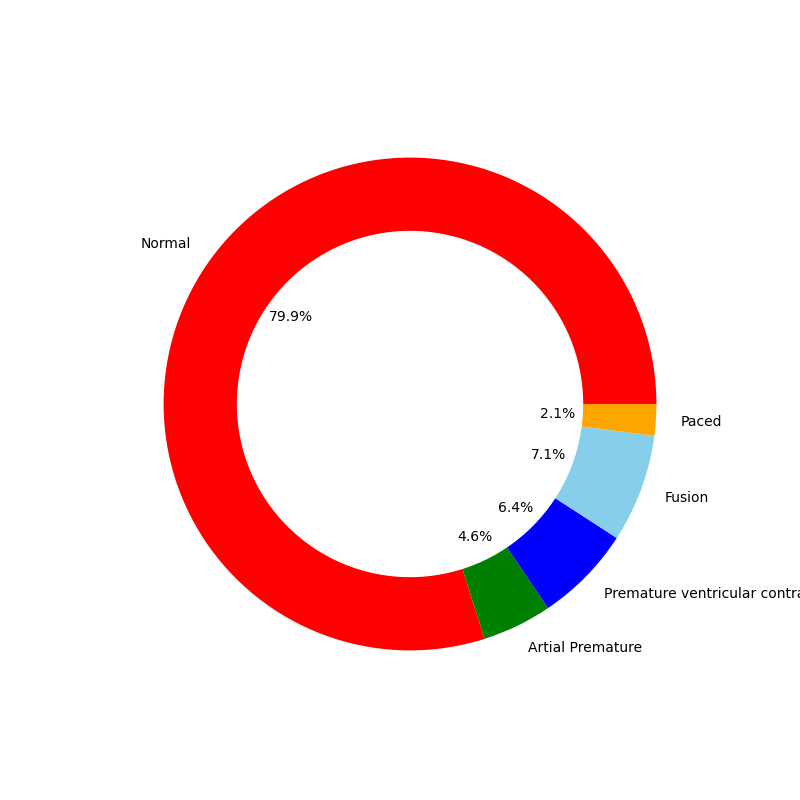

In [16]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [17]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    13589
2     1085
1      777
4     1206
3      351
Name: 187, dtype: int64


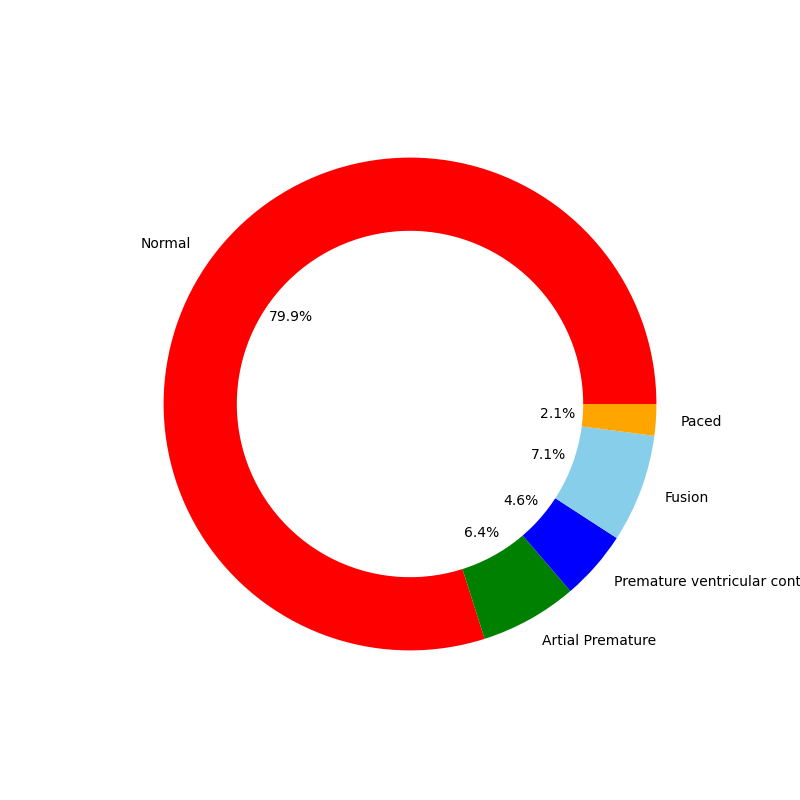

In [18]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Simple ANN

In [20]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
#save_model(model_ann, 'ANN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2410/2410 [==============================] - 9s 3ms/step - loss: 0.2229 - accuracy: 0.9365 - val_loss: 0.1426 - val_accuracy: 0.9593
Epoch 2/40
2410/2410 [==============================] - 7s 3ms/step - loss: 0.1338 - accuracy: 0.9614 - val_loss: 0.1413 - val_accuracy: 0.9608
Epoch 3/40
2410/2410 [==============================] - 7s 3ms/step - loss: 0.1092 - accuracy: 0.9687 - val_loss: 0.1107 - val_accuracy: 0.9662
Epoch 4/40
2410/2410 [==============================] - 7s 3ms/step - loss: 0.0964 - accuracy: 0.9723 - val_loss: 0.1209 - val_accuracy: 0.9674
Epoch 5/40
2410/2410 [==============================] - 6s 3ms/step - loss: 0.0876 - accuracy: 0.9740 - val_loss: 0.0965 - val_accuracy: 0.9731
Epoch 6/40
2410/2410 [==============================] - 6s 3ms/step - loss: 0.0804 - accuracy: 0.9759 - val_loss: 0.1003 - val_accuracy: 0.9718
Epoch 7/40
2410/2410 [==============================] - 6s 3ms/step - loss: 0.0741 - accuracy: 0.9774 - val_loss: 0.0929 - val_accuracy:

TypeError: save_model() missing 1 required positional argument: 'report'

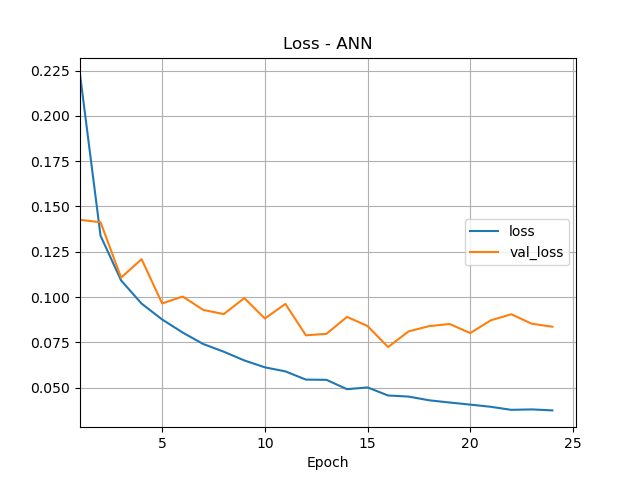

In [21]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

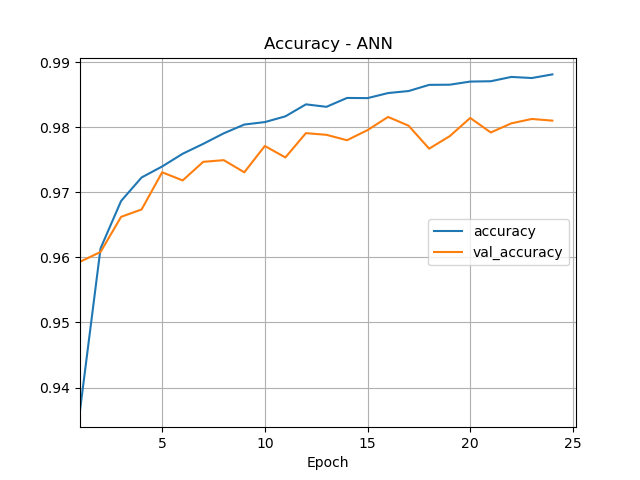

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

532/532 [==============================] - 1s 956us/step
Accuracy of ANN:  0.9813029162746942


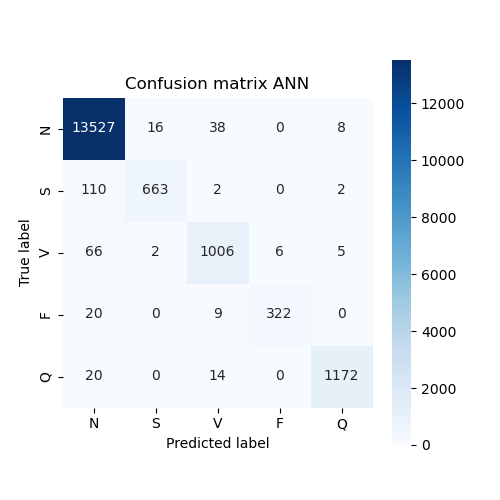

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [25]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                           Normal     0.9843    0.9954    0.9898     13589
                 Artial Premature     0.9736    0.8533    0.9095       777
Premature ventricular contraction     0.9411    0.9272    0.9341      1085
                           Fusion     0.9817    0.9174    0.9485       351
                            Paced     0.9874    0.9718    0.9795      1206

                         accuracy                         0.9813     17008
                        macro avg     0.9736    0.9330    0.9523     17008
                     weighted avg     0.9812    0.9813    0.9810     17008



### CNN

In [41]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=6, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2410/2410 [==============================] - 28s 11ms/step - loss: 0.1720 - accuracy: 0.9511 - val_loss: 0.1286 - val_accuracy: 0.9657
Epoch 2/40
2410/2410 [==============================] - 26s 11ms/step - loss: 0.1014 - accuracy: 0.9717 - val_loss: 0.1277 - val_accuracy: 0.9616
Epoch 3/40
2410/2410 [==============================] - 28s 12ms/step - loss: 0.0768 - accuracy: 0.9780 - val_loss: 0.0762 - val_accuracy: 0.9781
Epoch 4/40
2410/2410 [==============================] - 33s 14ms/step - loss: 0.0650 - accuracy: 0.9808 - val_loss: 0.0922 - val_accuracy: 0.9736
Epoch 5/40
2410/2410 [==============================] - 27s 11ms/step - loss: 0.0578 - accuracy: 0.9829 - val_loss: 0.1069 - val_accuracy: 0.9657
Epoch 6/40
2410/2410 [==============================] - 30s 12ms/step - loss: 0.0520 - accuracy: 0.9843 - val_loss: 0.0718 - val_accuracy: 0.9791
Epoch 7/40
2410/2410 [==============================] - 31s 13ms/step - loss: 0.0455 - accuracy: 0.9859 - val_loss: 0.0742 -

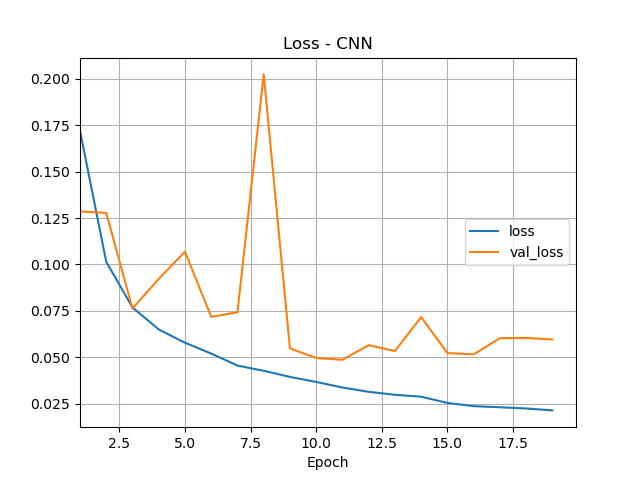

In [42]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

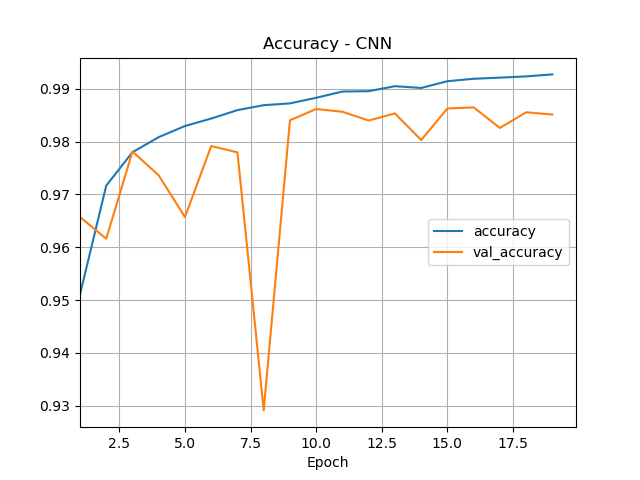

In [43]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [44]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

532/532 [==============================] - 2s 3ms/step
Accuracy of CNN:  0.9867121354656632


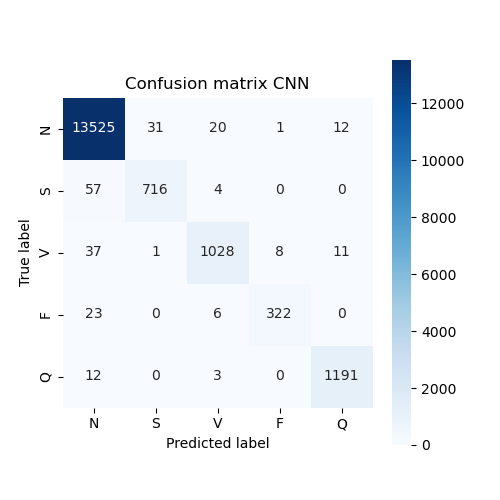

In [45]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [46]:
report = classification_report(y_test, y_pred_cnn, target_names=labels, digits=4)
print(report)

                                   precision    recall  f1-score   support

                           Normal     0.9906    0.9953    0.9929     13589
                 Artial Premature     0.9572    0.9215    0.9390       777
Premature ventricular contraction     0.9689    0.9475    0.9581      1085
                           Fusion     0.9728    0.9174    0.9443       351
                            Paced     0.9811    0.9876    0.9843      1206

                         accuracy                         0.9867     17008
                        macro avg     0.9741    0.9538    0.9637     17008
                     weighted avg     0.9866    0.9867    0.9866     17008



In [48]:
model_cnn.load_weights('best_cnn_5.h5')
save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras', report)